**USING RESNET18 WITH AND WITHOUT PRETRAINED WEIGHTS**

**LOADING THE SSL MODEL AND TRAINING A CLASSIFIER ON TOP OF IT**

Reference 1: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

Reference 2: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
%load_ext pycodestyle_magic

In [2]:
%pycodestyle_on

In [3]:
# Reproducibility.
SEED = 42

EPOCHS = 10

***

***

# Imports

## Libraries and modules

In [4]:
import os

import torch
import torchvision

from torchinfo import summary

import lightly
from lightly.models.modules.heads import SimSiamPredictionHead
from lightly.models.modules.heads import SimSiamProjectionHead

import matplotlib.pyplot as plt
import numpy as np
import math
import random

# Training checks.
import time

# Showing images in the notebook.
from IPython.display import Image
from IPython.core.display import HTML

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

## Settings

In [5]:
# Hyperparamenters.
input_size = 224  # old_input_size = 256
batch_size = 128   # old_batch_size = 128
num_workers = 8

# Dimension of the embeddings.
num_ftrs = 512

# Dimension of the output of the prediction and projection heads.
out_dim = proj_hidden_dim = 512

# The prediction head uses a bottleneck architecture.
pred_hidden_dim = 128

## Reproducibility

In [6]:
# Seed torch and numpy.
os.environ['PYTHONHASHSEED'] = str(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Enable CUDNN deterministic mode.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Issues a warning if it is not met.
torch.use_deterministic_algorithms(True)

In [7]:
# For dataloaders.
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(SEED)

In [8]:
# Enable deterministic behavior using external GPU.
# %env CUBLAS_WORKSPACE_CONFIG=:4096:8
# %env CUBLAS_WORKSPACE_CONFIG=:16:8
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

***

***

# Loading dataset

In [9]:
data_dir_target = 'datasets/Sentinel2GlobalLULC_full_ratio_seed=' \
                  + str(SEED)

## Custom tranforms (w/o normalization)

Define the augmentations for self-supervised learning.

In [10]:
# Data augmentations for the train dataset.
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.RandomResizedCrop(size=input_size,
                                             scale=(0.2, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.GaussianBlur(21),
    torchvision.transforms.ToTensor(),
])

# Data augmentations for the val and test datasets.
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
])

## ImageFolder

In [11]:
# Loading the three datasets.
train_data = torchvision.datasets.ImageFolder(data_dir_target + '/train/',
                                              transform=train_transform)

val_data = torchvision.datasets.ImageFolder(data_dir_target + '/val/',
                                            transform=test_transform)

test_data = torchvision.datasets.ImageFolder(data_dir_target + '/test/',
                                             transform=test_transform)

In [12]:
# Get classes and number.
class_names = train_data.classes
print(class_names)

['01_BarrenLands___jpeg', '02_MossAndLichen_jpeg', '03_Grasslands____jpeg', '04_ShrublandOpen_jpeg', '05_SrublandClose_jpeg', '06_ForestsOpDeBr_jpeg', '07_ForestsClDeBr_jpeg', '08_ForestsDeDeBr_jpeg', '09_ForestsOpDeNe_jpeg', '10_ForestsClDeNe_jpeg', '11_ForestsDeDeNe_jpeg', '12_ForestsOpEvBr_jpeg', '13_ForestsClEvBr_jpeg', '14_ForestsDeEvBr_jpeg', '15_ForestsOpEvNe_jpeg', '16_ForestsClEvNe_jpeg', '17_ForestsDeEvNe_jpeg', '18_WetlandMangro_jpeg', '19_WetlandSwamps_jpeg', '20_WetlandMarshl_jpeg', '21_WaterBodyMari_jpeg', '22_WaterBodyCont_jpeg', '23_PermanentSnow_jpeg', '24_CropSeasWater_jpeg', '25_CropCereaIrri_jpeg', '26_CropCereaRain_jpeg', '27_CropBroadIrri_jpeg', '28_CropBroadRain_jpeg', '29_UrbanBlUpArea_jpeg']


## PyTorch dataloaders

In [13]:
# Dataloader for training.
dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

# Dataloader for validating.
dataloader_val = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

# Dataloader for embedding.
dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

## Check the balance and size of the dataset

In [14]:
# Check samples per class in train dataset.
print(np.unique(train_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([9800, 3259, 6208, 9800, 8355, 3105,  943, 9800, 7306, 4466, 2015,
        396,  880, 9800, 2739, 2710, 9793,  291,  340, 2943, 9800, 9800,
       9800, 1402,  589,  714,  247,  289, 8813]))


In [15]:
# Check samples per class in test dataset.
print(np.unique(test_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([2800,  932, 1775, 2800, 2389,  889,  271, 2800, 2089, 1276,  577,
        115,  253, 2800,  784,  775, 2799,   84,   99,  842, 2800, 2800,
       2800,  402,  169,  204,   71,   83, 2518]))


In [16]:
# Print some stats from the train dataloader.
print('N samples in train dataset: ' + str(len(dataloader_train.sampler)))
print('N samples in train dataset: ' + str(len(dataloader_train.dataset)))
print('N batches in train dataset: ' + str(len(dataloader_train)))

N samples in train dataset: 136403
N samples in train dataset: 136403
N batches in train dataset: 1065


In [17]:
# Print some stats from the val dataloader.
print('N samples in val dataset: ' + str(len(dataloader_val.dataset)))
print('N batches in val dataset: ' + str(len(dataloader_val)))

N samples in val dataset: 19478
N batches in val dataset: 152


In [18]:
# Print some stats from the test dataloader.
print('N samples in val dataset: ' + str(len(dataloader_test.dataset)))
print('N batches in val dataset: ' + str(len(dataloader_test)))

N samples in val dataset: 38996
N batches in val dataset: 305


In [19]:
# Check the size of each dataset.
print(len(train_data.targets))
print(len(val_data.targets))
print(len(test_data.targets))

136403
19478
38996


## See some samples (pytorch dataset)

Feature batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])


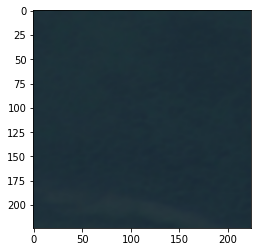

Label: 11_ForestsDeDeNe_jpeg


In [20]:
# Display image and label.
train_features, train_labels = next(iter(dataloader_train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(torch.permute(img, (1, 2, 0)), cmap="gray")
plt.show()
print(f"Label: {class_names[label]}")

***

***

# Training loop

In [21]:
# Training on GPU.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
# Training function.
def train_model(model, criterion, optimizer, device, epochs=10):
    """
    Main training function.

    """

    print(f"Using {device} device")

    # Avoiding "CUDA out of memory" in PyTorch.
    torch.cuda.empty_cache()

    # Loss history.
    loss_values = {}
    loss_values['train'] = []
    loss_values['val'] = []
    total_time = 0

    # Model to GPU if available.
    model.to(device)

    # Iterating over the epochs.
    for epoch in range(epochs):

        # Initialize training loss.
        running_train_loss = 0.0

        # Start timer.
        since = time.time()

        for i, data in enumerate(dataloader_train):

            # Get the inputs; data is a list of [inputs, labels].
            inputs, labels = data[0].to(device), data[1].to(device)

            # Enable training.
            model.train()

            # Zero the parameter gradients.
            optimizer.zero_grad()

            # Forward: make predictions.
            outputs = model(inputs)

            # Compute the loss and its gradients.
            loss = criterion(outputs, labels)
            loss.backward()

            # Averaged loss across all training examples * batch_size.
            running_train_loss += loss.item() * inputs.size(0)

            if i % 5000 == 4999:
                print(f'T[{epoch + 1}, {i + 1:5d}]')

            # Adjust learning weights.
            optimizer.step()

        # Loss averaged across all training examples for the current epoch.
        epoch_train_loss = running_train_loss / len(dataloader_train.sampler)

        # Change model to evaluation mode.
        model.eval()

        # Initialize validating loss.
        running_val_loss = 0.0
        with torch.no_grad():
            for j, vdata in enumerate(dataloader_val):

                # Get the inputs; data is a list of [inputs, labels].
                vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)

                # Forward: make predictions.
                voutputs = model(vinputs)

                # Compute the loss (w/o gradients).
                vloss = criterion(voutputs, vlabels)

                # Averaged loss across all validating examples * batch_size.
                running_val_loss += vloss.item() * vinputs.size(0)

                if j % 1000 == 999:
                    print(f'V[{epoch + 1}, {j + 1:5d}]')

        # Loss averaged across all validating examples for the current epoch.
        epoch_val_loss = running_val_loss / len(dataloader_val.sampler)

        # Append loss values.
        loss_values['train'].append(epoch_train_loss)
        loss_values['val'].append(epoch_val_loss)

        # End timer.
        time_elapsed = time.time() - since
        total_time += time_elapsed

        # Show stats.
        print(f'Epoch: {epoch} | '
              f'Train loss: {epoch_train_loss:.4f} | '
              f'Val loss: {epoch_val_loss:.4f} | '
              f'Time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    print(f'\nTraining completed in {total_time // 60:.0f}m '
          f'{total_time % 60:.0f}s')

    return loss_values

In [23]:
def plot_losses(loss_history, title='', save_fig=False):
    """
    Function for plotting the training and validation losses

    """

    fig = plt.figure(figsize=(10, 5))
    plt.plot(loss_history['train'], label='Train')
    plt.plot(loss_history['val'], label='Validation')
    plt.xlabel('Epoch', labelpad=15)
    plt.ylabel('Loss', labelpad=15)
    plt.title(title)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gcf().subplots_adjust(left=0.15)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    if save_fig:
        fig.savefig('plt_loss_values.pdf', bbox_inches='tight')

In [24]:
def evaluation_on_test(model, device):
    """
    Function to evaluate the performance
    of the model on the test dataset.

    """

    # Avoiding "CUDA out of memory" in PyTorch.
    torch.cuda.empty_cache()

    correct = 0
    total = 0

    # Since we're not training, we don't need to calculate
    # the gradients for our outputs with torch.no_grad():
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader_test):

            # Dataset.
            inputs, labels = data[0].to(device), data[1].to(device)

            # Calculate outputs by running images through the network.
            outputs = model(inputs)

            # The class with the highest energy is what we
            # choose as prediction.
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Progress bar.
            if i % 50 == 49:
                print(f'Progress: {100 * i // len(dataloader_test)}%',
                      end='\r',
                      flush=True)

    print(f'Accuracy of the network on the {total} '
          f'test images: {100 * correct // total}%')

***

***

# ResNet18 from scrath

## Definition and hyperparameters

In [25]:
# Model: resnet with random weights.
model = torchvision.models.resnet18(weights=None)

## Adjust final layer

Type: linear not softmax for the moment.

In [26]:
# Check old final layer.
print(model.fc)

# Get the number of input features to the layer.
num_ftrs = model.fc.in_features
print(num_ftrs)

# Adjust the final layer to the current number of classes.
model.fc = torch.nn.Linear(num_ftrs, len(class_names))

# Check new final layer.
print(model.fc)

# Model structure.
# summary(model, input_size=(batch_size, 3, input_size, input_size))

Linear(in_features=512, out_features=1000, bias=True)
512
Linear(in_features=512, out_features=29, bias=True)


## Loss fcn and optimizer

In [27]:
# Loss function: cross-entropy loss.
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers: specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

## Training

Using cuda device
Epoch: 0 | Train loss: 0.7761 | Val loss: 0.8043 | Time: 4m 42s
Epoch: 1 | Train loss: 0.5319 | Val loss: 0.8661 | Time: 4m 34s
Epoch: 2 | Train loss: 0.4549 | Val loss: 1.2243 | Time: 4m 34s
Epoch: 3 | Train loss: 0.3974 | Val loss: 0.6457 | Time: 4m 32s
Epoch: 4 | Train loss: 0.3536 | Val loss: 2.8158 | Time: 4m 33s
Epoch: 5 | Train loss: 0.3078 | Val loss: 2.6736 | Time: 4m 33s
Epoch: 6 | Train loss: 0.2758 | Val loss: 3.4865 | Time: 4m 34s
Epoch: 7 | Train loss: 0.2479 | Val loss: 1.2802 | Time: 4m 33s
Epoch: 8 | Train loss: 0.2252 | Val loss: 6.5837 | Time: 4m 33s
Epoch: 9 | Train loss: 0.2086 | Val loss: 5.5728 | Time: 4m 34s

Training completed in 45m 42s


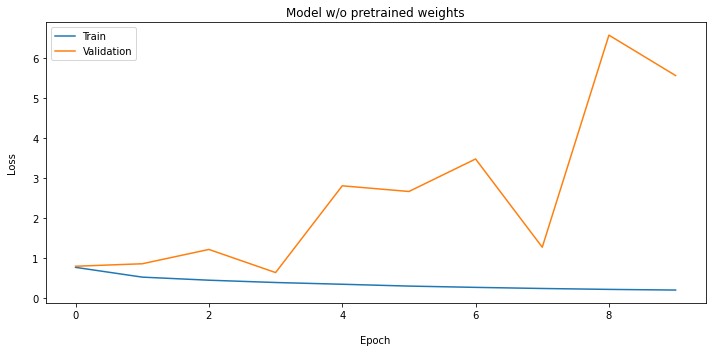

In [28]:
loss_history = train_model(
    model,
    loss_fn,
    optimizer,
    device,
    epochs=EPOCHS
)

plot_losses(loss_history, 'Model w/o pretrained weights')

## Check performance on test dataset

In [29]:
evaluation_on_test(model, device)

Accuracy of the network on the 38996 test images: 60%


***

***

# ResNet18 with pretrained weights

## Definition and hyperparameters

In [30]:
# Model: resnet with pretrained weights.
del model
model = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.DEFAULT
)

## Adjust final layer

In [31]:
# Check old final layer.
print(model.fc)

# Get the number of input features to the layer.
num_ftrs = model.fc.in_features
print(num_ftrs)

# Adjust the final layer to the current number of classes.
model.fc = torch.nn.Linear(num_ftrs, len(class_names))

# Check new final layer.
print(model.fc)

# Model structure.
# summary(model, input_size=(batch_size, 3, input_size, input_size))

Linear(in_features=512, out_features=1000, bias=True)
512
Linear(in_features=512, out_features=29, bias=True)


## Loss fcn and optimizer

In [32]:
# Loss function: cross-entropy loss.
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers: specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

## Training

Using cuda device
Epoch: 0 | Train loss: 0.3185 | Val loss: 0.3562 | Time: 4m 43s
Epoch: 1 | Train loss: 0.2171 | Val loss: 0.2246 | Time: 4m 58s
Epoch: 2 | Train loss: 0.1876 | Val loss: 0.2701 | Time: 5m 2s
Epoch: 3 | Train loss: 0.1795 | Val loss: 0.2837 | Time: 4m 50s
Epoch: 4 | Train loss: 0.1673 | Val loss: 0.2245 | Time: 4m 38s
Epoch: 5 | Train loss: 0.1594 | Val loss: 0.1979 | Time: 4m 35s
Epoch: 6 | Train loss: 0.1533 | Val loss: 0.1825 | Time: 4m 35s
Epoch: 7 | Train loss: 0.1492 | Val loss: 0.1350 | Time: 4m 35s
Epoch: 8 | Train loss: 0.1396 | Val loss: 0.1546 | Time: 4m 35s
Epoch: 9 | Train loss: 0.1345 | Val loss: 0.1299 | Time: 4m 34s

Training completed in 47m 6s


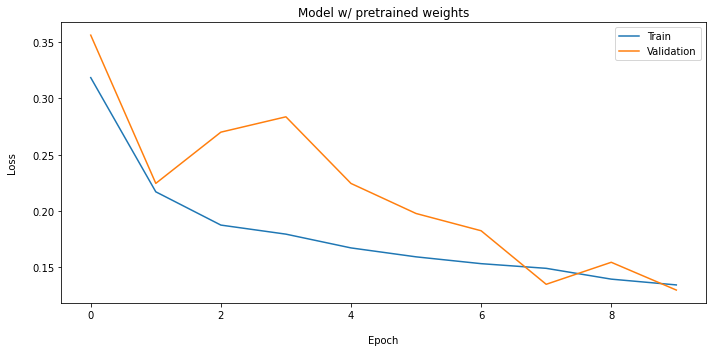

In [33]:
loss_history = train_model(
    model,
    loss_fn,
    optimizer,
    device,
    epochs=EPOCHS
)

plot_losses(loss_history, 'Model w/ pretrained weights')

## Check performance on test dataset

In [34]:
evaluation_on_test(model, device)

Accuracy of the network on the 38996 test images: 95%


***

***

# SSL model

## Loading

In [41]:
# State model class.
resnet18 = torchvision.models.resnet18(weights=None)

# Only backbone (w/o final fc layer).
pt_backbone = torch.nn.Sequential(*list(resnet18.children())[:-1])

# Loading model.
pt_backbone.load_state_dict(
    torch.load('pytorch_models/simsiam_backbone_resnet18')
)
# model.eval() or model.train()

<All keys matched successfully>

## Checking the weights

In [36]:
# First convolutional layer weights.
# print(backbone)
print(pt_backbone[0])
print(pt_backbone[0].weight[63])

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
tensor([[[-0.0458,  0.0060,  0.0031, -0.0006, -0.0370, -0.0172,  0.0293],
         [ 0.0013,  0.0222, -0.0185,  0.0043, -0.0204,  0.0254,  0.0179],
         [ 0.0193,  0.0082,  0.0130, -0.0048,  0.0020, -0.0357, -0.0040],
         [ 0.0499, -0.0338,  0.0088,  0.0223,  0.0045, -0.0013, -0.0565],
         [ 0.0090,  0.0244, -0.0079,  0.0057, -0.0204,  0.0147, -0.0153],
         [ 0.0347, -0.0023,  0.0279,  0.0344,  0.0236, -0.0012, -0.0014],
         [ 0.0206,  0.0053,  0.0187,  0.0488, -0.0343,  0.0014,  0.0531]],

        [[-0.0021, -0.0432, -0.0086,  0.0192, -0.0211,  0.0306, -0.0318],
         [-0.0404,  0.0169,  0.0279,  0.0031,  0.0748,  0.0129,  0.0074],
         [ 0.0272,  0.0082, -0.0502, -0.0173,  0.0031, -0.0407, -0.0117],
         [-0.0010,  0.0115, -0.0550, -0.0222,  0.0268,  0.0562,  0.0370],
         [ 0.0133, -0.0018,  0.0344,  0.0087,  0.0364, -0.0117,  0.0167],
         [ 0.0005, -0.0169, -0.02

## Adding a final linear layer

In [37]:
# Adding a linear layer on top of the model (linear classifier).
model_ssl = torch.nn.Sequential(
    pt_backbone,
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=512, out_features=len(class_names), bias=True),
    # torch.nn.Softmax(dim=1)
)

# Model structure.
# summary(model_ssl, input_size=(batch_size, 3, input_size, input_size))

## Loss fcn and optimizer

In [38]:
# Loss function: cross-entropy loss.
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers: specified in the torch.optim package
optimizer = torch.optim.Adam(model_ssl.parameters(),
                             lr=0.001)

## Training

Using cuda device
Epoch: 0 | Train loss: 0.8251 | Val loss: 1.1121 | Time: 4m 34s
Epoch: 1 | Train loss: 0.5358 | Val loss: 0.5220 | Time: 4m 35s
Epoch: 2 | Train loss: 0.4574 | Val loss: 3.8313 | Time: 4m 36s
Epoch: 3 | Train loss: 0.3889 | Val loss: 0.4092 | Time: 4m 35s
Epoch: 4 | Train loss: 0.3391 | Val loss: 0.4237 | Time: 4m 35s
Epoch: 5 | Train loss: 0.3044 | Val loss: 0.3686 | Time: 4m 34s
Epoch: 6 | Train loss: 0.2644 | Val loss: 0.6420 | Time: 4m 35s
Epoch: 7 | Train loss: 0.2406 | Val loss: 0.3837 | Time: 4m 35s
Epoch: 8 | Train loss: 0.2220 | Val loss: 0.3671 | Time: 4m 34s
Epoch: 9 | Train loss: 0.2096 | Val loss: 0.5035 | Time: 4m 35s

Training completed in 45m 47s


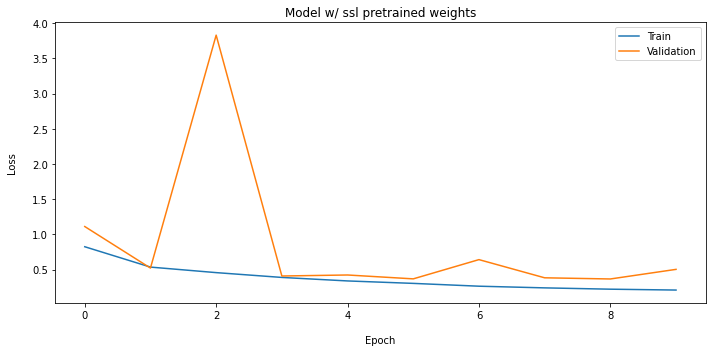

1:80: E501 line too long (80 > 79 characters)


In [39]:
loss_history = train_model(
    model_ssl,
    loss_fn,
    optimizer,
    device,
    epochs=EPOCHS
)

plot_losses(loss_history, 'Model w/ ssl pretrained weights')

## Check performance on test dataset

In [40]:
evaluation_on_test(model_ssl, device)

Accuracy of the network on the 38996 test images: 82%


***

***

***

***

***

***

***

# OLD

In [ ]:
# Adding a linear layer on top of the model (linear classifier).
model_ft = torch.nn.Sequential(
    pretrained_model,
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=512, out_features=num_classes, bias=True),
    # torch.nn.Softmax(dim=1)
)

In [ ]:
summary(model_ft, input_size=(batch_size, 3, input_size, input_size))

In [ ]:
from torch.optim import lr_scheduler

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 16))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} |\n'
                             f'real: {class_names[labels.cpu().data[j]]}')
                
                plt.imshow(torch.permute(inputs.cpu().data[j], (1, 2, 0)))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model_ft, num_images=8)